In [13]:
import sys
sys.path.append('../')
from tqdm.auto import tqdm
from loader import get_dataloader
from augmentations import get_composed_augmentations
import torch

from tqdm.notebook import tqdm

from torch.nn.functional import softmax

import sys
sys.path.append('../')
from utils import roc_btw_arr

import matplotlib.pyplot as plt

In [6]:
fgvc_dl = get_dataloader({'dataset': 'FGVC', 
                           'split':'evaluation', 
                           'path': '../datasets', 
                           'batch_size': 8, 
                           'n_workers': 2, 
                           'shuffle':False})

Using No Augmentations
Using No Augmentations


In [137]:
xx,_ = next(iter(fgvc_dl))

In [16]:
from attacks.transforms import apply_affine_batch
from torchvision.utils import make_grid

In [145]:
factors = torch.rand(8, 5)
zz = apply_affine_batch(xx, factors)

In [332]:
# new_factors = torch.cat([factors[:,:4], torch.ones(8,1) * 1], dim=1)
new_factors = torch.ones(8, 5) * 0.5
new_factors[:,4] = 0.
zz = apply_affine_batch(xx, new_factors, scale_bound=(0.9, 1.1))

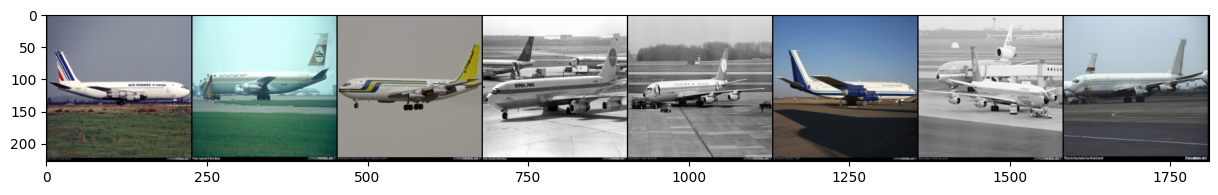

In [315]:
plt.figure(figsize=(15,15))
plt.imshow(make_grid(xx).permute(1,2,0))

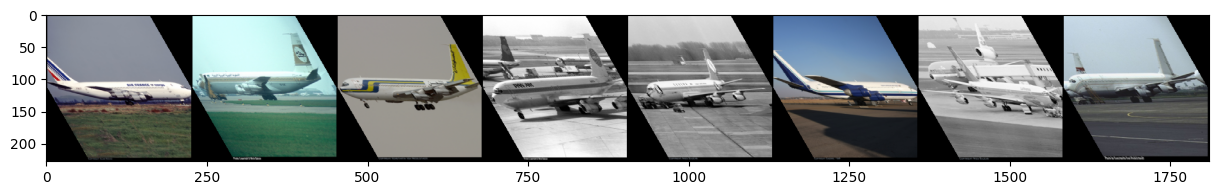

In [333]:
plt.figure(figsize=(15,15))
plt.imshow(make_grid(zz).permute(1,2,0))

In [163]:
import kornia

In [272]:
# x = torch.rand(8, 5)
x = factors
x = torch.cat([factors[:,:4], torch.ones(8,1) * 0.7], dim=1)
x = torch.ones(8,5) * 0.5
a_bound=(-90, 90)
tx_bound=(-10, 10)
ty_bound=(-10, 10)
scale_bound=(0.9, 1.1)
shear_bound=(-30, 30)

In [273]:
aa = x[:, 0] * (a_bound[1] - a_bound[0]) + a_bound[0]
tx = x[:, 1] * (tx_bound[1] - tx_bound[0]) + tx_bound[0]
ty = x[:, 2] * (ty_bound[1] - ty_bound[0]) + ty_bound[0]
sc = x[:, 3] * (scale_bound[1] - scale_bound[0]) + scale_bound[0]
sh = x[:, 4] * (shear_bound[1] - shear_bound[0]) + shear_bound[0]

In [278]:
sh

tensor([0., 0., 0., 0., 0., 0., 0., 0.])

In [296]:
import numpy as np

In [327]:
matrix = kornia.geometry.get_affine_matrix2d(translations=torch.zeros(8,2), #torch.stack([tx,ty],dim=1),
                                             center=torch.ones(8,2) * 111.5,
                                             scale=torch.stack([sc, sc],dim=1),
                                             angle=aa,
                                             sx=-torch.ones(8,)*(1/np.sqrt(3)), 
                                             # sy=torch.ones(8,)*(1/np.sqrt(3)),
                                             # sy=torch.zeros(8,)
                                            )

In [328]:
# yy = kornia.geometry.warp_perspective(xx, matrix, dsize=(224,224))
yy = kornia.geometry.warp_affine(xx, matrix[:,:2,:3], dsize=(224,224))

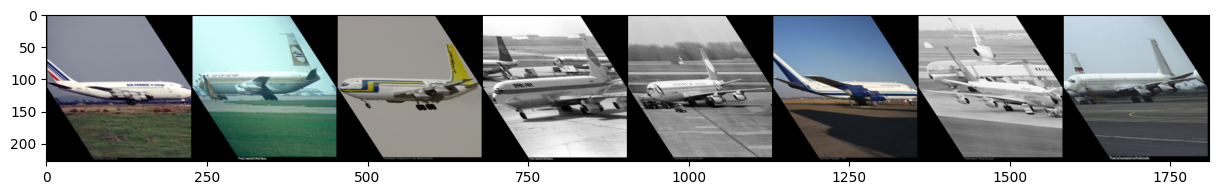

In [329]:
plt.figure(figsize=(15,15))
plt.imshow(make_grid(yy).permute(1,2,0))

In [158]:
factors[3]

tensor([0.4698, 0.3729, 0.1172, 0.5857, 0.5205])

In [159]:
((zz - yy) ** 2).sum()

tensor(739.6657)

In [ ]:
def apply_colortransform_batch(
    img,
    x,
    b_bound=(0.5, 1.5),
    c_bound=(0.5, 1.5),
    s_bound=(0.0, 2.0),
    h_bound=(-0.5, 0.5),
):
    """
    img: [N, 3, H, W], torch.Tensor
    x: [N, 4], torch.Tensor. bounded to [0, 1]
    b_bound, c_bound, s_bound, h_bound: bounds of brightness_factor, contrast_factor, saturation_factor, hue_factor
    brightness, contrast, saturation, hue: scalar or 1D tensor that has the length N
    """
    bb = x[:, 0] * (b_bound[1] - b_bound[0]) + b_bound[0]
    cc = x[:, 1] * (c_bound[1] - c_bound[0]) + c_bound[0]
    ss = x[:, 2] * (s_bound[1] - s_bound[0]) + s_bound[0]
    hh = x[:, 3] * (h_bound[1] - h_bound[0]) + h_bound[0]
    l_batch = []
    for img_, b, c, s, h in zip(img, bb, cc, ss, hh):
        img_ = TF.adjust_brightness(img_, brightness_factor=b)
        img_ = TF.adjust_contrast(img_, contrast_factor=c)
        img_ = TF.adjust_saturation(img_, saturation_factor=s)
        img_ = TF.adjust_hue(img_, hue_factor=h)
        l_batch.append(img_)
    return torch.stack(l_batch)

In [137]:
xx,_ = next(iter(fgvc_dl))

In [334]:
from attacks.transforms import apply_colortransform_batch
from torchvision.utils import make_grid

In [335]:
factors = torch.rand(8, 4)
zz = apply_colortransform_batch(xx, factors)

In [336]:
# new_factors = torch.cat([factors[:,:4], torch.ones(8,1) * 1], dim=1)
# new_factors = torch.ones(8, 4) #* 0.5
# new_factors[:,4] = 0.
zz = apply_colortransform_batch(xx, factors)

In [346]:
factors

tensor([[5.1287e-01, 3.6855e-01, 8.8116e-01, 2.6238e-01],
        [8.7212e-01, 6.6654e-01, 5.3288e-01, 3.2524e-01],
        [4.6757e-02, 8.1386e-01, 9.2155e-01, 9.9402e-01],
        [4.1044e-01, 4.0122e-01, 7.0056e-01, 4.4757e-01],
        [3.1140e-02, 2.0382e-01, 2.6485e-01, 3.3716e-01],
        [9.1744e-01, 5.5654e-01, 7.3319e-01, 6.4593e-01],
        [7.2245e-01, 9.5656e-01, 4.4551e-01, 2.6306e-01],
        [5.8853e-01, 9.8825e-05, 1.7910e-01, 6.2292e-01]])

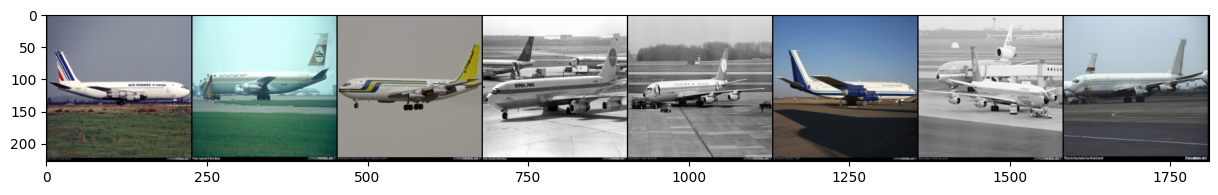

In [337]:
plt.figure(figsize=(15,15))
plt.imshow(make_grid(xx).permute(1,2,0))

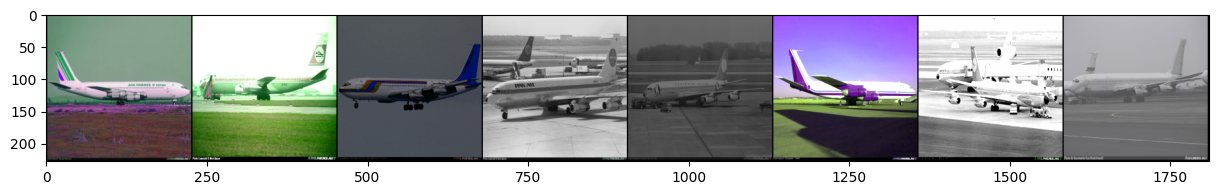

In [338]:
plt.figure(figsize=(15,15))
plt.imshow(make_grid(zz).permute(1,2,0))

In [342]:
b_bound=(0.5, 1.5)
c_bound=(0.5, 1.5)
s_bound=(0, 2)
h_bound=(-0.5, 0.5)

In [383]:
factors = torch.ones(8, 4) * 0.5
factors[:,3] = 0.1

In [384]:
x = factors
bb = x[:, 0] * (b_bound[1] - b_bound[0]) + b_bound[0]
cc = x[:, 1] * (c_bound[1] - c_bound[0]) + c_bound[0]
ss = x[:, 2] * (s_bound[1] - s_bound[0]) + s_bound[0]
hh = x[:, 3] * (h_bound[1] - h_bound[0]) + h_bound[0]


In [385]:
# jitter = kornia.augmentation.ColorJitter(brightness=bb, contrast=cc, saturation=ss, hue=hh)
# yy = jitter(xx)
yy = kornia.enhance.adjust_brightness_accumulative(xx, bb)
yy = kornia.enhance.adjust_contrast_with_mean_subtraction(yy, cc)
yy = kornia.enhance.adjust_saturation_with_gray_subtraction(yy, ss)
yy = kornia.enhance.adjust_hue(yy, hh * 2 * np.pi)
# kornia.enhance.adjust_hue()

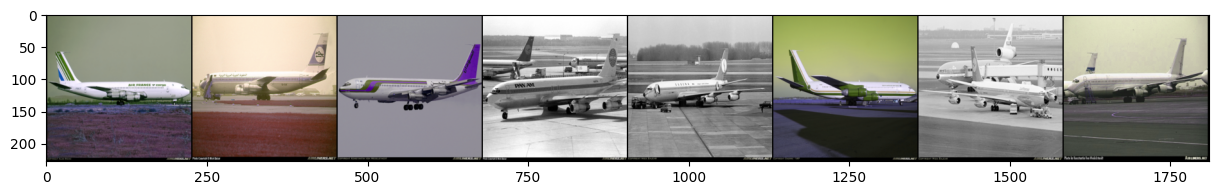

In [386]:
plt.figure(figsize=(15,15))
plt.imshow(make_grid(yy).permute(1,2,0))

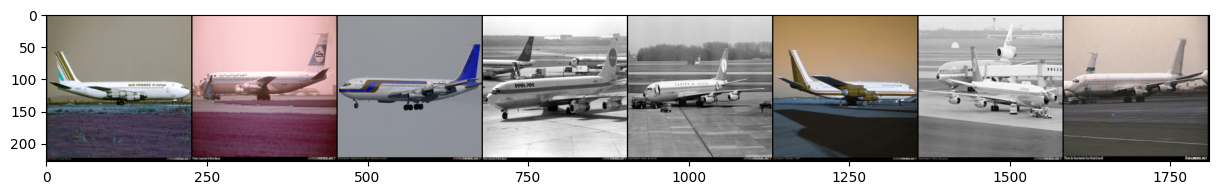

In [382]:
plt.figure(figsize=(15,15))
plt.imshow(make_grid(yy).permute(1,2,0))